# Import modules

In [0]:
import os

# make only specific GPU to be utilized
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# select GPU to run on
GPU = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

# stop GPU
# os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

# set GPU to be deterministic 
os.environ["PYTHONHASHSEED"] = "0" # set hash environment
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0" # use cuDNN function to retrieve the best algorithm
os.environ["TF_CUDNN_CONVOLUTION_BWD_FILTER_ALGO_DETERMINISTIC"]='1' # use cuDNN deterministic algorithms
os.environ['TF_DETERMINISTIC_OPS'] = '1' # deterministic setting

# set numpy, python, tensorflow random seed
from numpy.random import seed
import random
random.seed(10)
seed(10)
from tensorflow import set_random_seed
set_random_seed(20)

# GPU memory control
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.Session(config=config)

In [380]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from nltk import tokenize

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set up parameters

In [0]:
start_date = "2016-01-01"# "2015-01-01" # "2016-01-01"
end_date = "2017-12-31"# "2016-12-31" # "2017-12-31"
pad_maxlen = 50
encoding_mode = "tokenize" ## "tokenize", "bpe"
calculation_mode = "surprise" ## "surprise", "category"
surprise_level = 0 # 0, 5
category_list = ["CRIME", "BUSINESS", "IMPACT"]  #["CRIME", "BUSINESS", "IMPACT", "POLITICS", "MONEY"] # ["CRIME", "BUSINESS", "IMPACT"] # "All", ["CRIME", "MONEY", "BUSINESS", "IMPACT"]

# Get News-category-dataset

In [0]:
# https://www.kaggle.com/rmisra/news-category-dataset
# https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65
# https://www.kaggle.com/hsankesara/news-classification-using-han

In [383]:
ls data

merge_data.csv  News_Category_Dataset_v2.json  USDJPY.txt  word_index.npy


In [384]:
# load data
df = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)
df.head(2)

,category,headline,authors,link,short_description,date
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201,Of course it has a song.,2018-05-26


In [385]:
df.tail(2)

,category,headline,authors,link,short_description,date
25869,ENTERTAINMENT,Reese Witherspoon Surprises Students Living In Her Old Dorm Room,David Moye,https://www.huffingtonpost.com/entry/reese-witherspoon-dorm-room_us_5924941ce4b00c8df29f87f5,One Stanford student got an unexpected visitor last weekend.,2017-05-23
25870,PARENTS,Mom Does Hilariously Accurate Impression Of Toddlers,Caroline Bologna,https://www.huffingtonpost.com/entry/mom-does-hilariously-accurate-impression-of-toddlers_us_59235677e4b03b485cb42ec2,This is hilarious!,2017-05-23


In [386]:
cates = df.groupby('category')
print (df["category"].unique())
print (df.count())
print("total categories:", cates.ngroups)
print(cates.size())

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS']
category             25871
headline             25871
authors              25871
link                 25871
short_description    25871
date                 25871
dtype: int64
total categories: 28
category
ARTS & CULTURE    186 
BLACK VOICES      958 
BUSINESS          332 
COLLEGE           38  
COMEDY            999 
CRIME             391 
EDUCATION         184 
ENTERTAINMENT     3544
GOOD NEWS         9   
GREEN             399 
HEALTHY LIVING    901 
IMPACT            313 
LATINO VOICES     270 
MEDIA             700 
PARENTS           744 
POLITICS          9134
QUEER VOICES      1365
RELIGION          274 
SCIENCE           94  
SPORTS            580 
STYLE        

In [0]:
# Merge THE WORLDPOST and WORLDPOST should be the same category

df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
# cates = df.groupby('category')
# print("total categories:", cates.ngroups)
# print(cates.size())

In [388]:
# Select category
if category_list == "All":
    df = df
else:
    select_category_list = category_list
    df = df[df['category'].isin(select_category_list)]
df["category"].unique()

array(['CRIME', 'IMPACT', 'BUSINESS'], dtype=object)

In [389]:
df[df.isnull().any(axis=1)]

,category,headline,authors,link,short_description,date


# Process data

In [0]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

In [391]:
# using headlines and short_description as input X

df['text'] = df['headline'] + " " + df['short_description']
# df['text'] = df['headline']
df.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,category,headline,authors,link,short_description,date,text
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,2018-05-26,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America."
12,IMPACT,"With Its Way Of Life At Risk, This Remote Oyster-Growing Region Called In Robots",Karen Pinchin,https://www.huffingtonpost.com/entry/remote-oyster-growing-region-called-in-robots_us_5b083658e4b0fdb2aa53415d,The revolution is coming to rural New Brunswick.,2018-05-26,"With Its Way Of Life At Risk, This Remote Oyster-Growing Region Called In Robots The revolution is coming to rural New Brunswick."


In [392]:
df = df[['date','text','category']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 25818
Data columns (total 3 columns):
date        1036 non-null datetime64[ns]
text        1036 non-null object
category    1036 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 32.4+ KB


In [393]:
df = df.reset_index()
del df['index']
df.head()

,date,text,category
0,2018-05-26,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America.",CRIME
1,2018-05-26,"With Its Way Of Life At Risk, This Remote Oyster-Growing Region Called In Robots The revolution is coming to rural New Brunswick.",IMPACT
2,2018-05-25,"Rachel Dolezal Faces Felony Charges For Welfare Fraud State prosecutors say almost $84,000 had been deposited into her bank account while she was receiving public assistance.",CRIME
3,2018-05-25,"Man Faces Charges After Pulling Knife, Stun Gun On Muslim Students At McDonald's “We thought we were going to die,"" one of the students said.",CRIME
4,2018-05-25,"2 People Injured In Indiana School Shooting A male student, believed to be the suspect, has been detained, according to police.",CRIME


## clean string

In [0]:
# https://machinelearningmastery.com/clean-text-machine-learning-python/

In [0]:
# df["text"][0]

In [0]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
def clean_text(text):
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    #print ("tokens", tokens)
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    #print("words", words[:100])
    
#     # stemming of words
#     porter = PorterStemmer()
#     stemmed = [porter.stem(word) for word in words]
#     print("stem",stemmed[:100])

    sentence = ' '.join(words)
    return sentence

In [0]:
# ! pip install -U nltk
# ! python -m nltk.downloader all

In [0]:
texts = []
for idx in range(df.text.shape[0]):
    #print (idx, df.text[idx])
    text = clean_text(df.text[idx])
    #print (text)
    texts.append(text)
df["text"] = pd.Series(texts)

In [0]:
# df["text"]

In [400]:
df.head(2)

,date,text,category
0,2018-05-26,mass shootings texas last week tv left husband killed children another day america,CRIME
1,2018-05-26,way life risk remote oystergrowing region called robots revolution coming rural new brunswick,IMPACT


## byte pair encoding

In [0]:
# !pip install keras_gpt_2

In [0]:
# import keras_gpt_2 
# from keras_gpt_2 import load_trained_model_from_checkpoint, get_bpe_from_files, generate
# model_folder = 'gpt-2/models/117M' # 117M, 345M, 774M, 1558M
# model_folder=os.path.abspath(model_folder)
# config_path = os.path.join(model_folder, 'hparams.json')
# checkpoint_path = os.path.join(model_folder, 'model.ckpt')
# encoder_path = os.path.join(model_folder, 'encoder.json')
# vocab_path = os.path.join(model_folder, 'vocab.bpe')

# bpe = get_bpe_from_files(encoder_path, vocab_path)

In [0]:
# df["bpe"] = [bpe.encode(text) for text in df["text"]]
# df.head()

## tokenizing

In [0]:
# df.text

In [405]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

df.head()

,date,text,category,words,word_length
0,2018-05-26,mass shootings texas last week tv left husband killed children another day america,CRIME,"[81, 186, 28, 37, 98, 794, 90, 187, 34, 47, 150, 19, 60]",13
1,2018-05-26,way life risk remote oystergrowing region called robots revolution coming rural new brunswick,IMPACT,"[151, 76, 289, 2459, 2460, 2461, 152, 597, 1514, 170, 1077, 2, 2462]",13
2,2018-05-25,rachel dolezal faces felony charges welfare fraud state prosecutors say almost deposited bank account receiving public assistance,CRIME,"[1515, 2463, 128, 1516, 109, 1078, 249, 55, 598, 14, 481, 2464, 188, 1079, 1080, 110, 795]",17
3,2018-05-25,man faces charges pulling knife stun gun muslim students mcdonald thought going die one students said,CRIME,"[5, 128, 109, 2465, 1081, 2466, 61, 796, 338, 2467, 1082, 153, 290, 7, 338, 4]",16
4,2018-05-25,people injured indiana school shooting male student believed suspect detained according police,CRIME,"[3, 291, 1083, 25, 9, 797, 171, 599, 21, 2468, 189, 1]",12


In [0]:
# tokenizer.word_index.items()

In [407]:
df.word_length.describe()

count    1036.000000
mean     15.883205  
std      3.812878   
min      6.000000   
25%      14.000000  
50%      16.000000  
75%      18.000000  
max      29.000000  
Name: word_length, dtype: float64

In [0]:
# padding length
X = list(sequence.pad_sequences(df.words, maxlen=pad_maxlen))

In [409]:
# category to id

categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])
print (df['c2id'].unique())

[1 2 0]


## glove embedding

In [0]:
# download glove pre-trained word vectors
# https://github.com/stanfordnlp/GloVe

In [0]:
# word_index = tokenizer.word_index

# EMBEDDING_DIM = 100

# embeddings_index = {}
# f = open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s unique tokens.' % len(word_index))
# print('Total %s word vectors.' % len(embeddings_index))

In [0]:
# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

# embedding_layer = Embedding(len(word_index)+1,
#                             EMBEDDING_DIM,
#                             embeddings_initializer=Constant(embedding_matrix),
#                             input_length=maxlen,
#                             trainable=False)

## select data

In [413]:
df_news = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
df_news.head(1)

,date,text,category,words,word_length,c2id
337,2017-12-31,minimum wage raises coming states new year day hikes less quarter hour making minimum wage every penny counts,BUSINESS,"[1968, 1334, 855, 170, 284, 2, 38, 19, 3497, 298, 982, 953, 245, 1968, 1334, 107, 3498, 819]",18,0


In [414]:
df_news.tail(1)

,date,text,category,words,word_length,c2id
1035,2017-05-24,behaviors highlight leadership ability based years experience new business advisor always find leadership important business success,BUSINESS,"[5799, 5800, 433, 771, 1433, 13, 2126, 2, 46, 2445, 193, 139, 433, 1021, 46, 749]",16,0


In [415]:
# df_news = df_news[["date","words", "category", "c2id", "word_length","text","bpe"]]
df_news = df_news[["date","words", "category", "c2id", "word_length","text"]]
df_news.head(1)

,date,words,category,c2id,word_length,text
337,2017-12-31,"[1968, 1334, 855, 170, 284, 2, 38, 19, 3497, 298, 982, 953, 245, 1968, 1334, 107, 3498, 819]",BUSINESS,0,18,minimum wage raises coming states new year day hikes less quarter hour making minimum wage every penny counts


In [416]:
df_news["c2id"].unique()

array([0, 1, 2])

## save word index

In [0]:
word_index = tokenizer.word_index
# print (word_index)

In [418]:
np.save('data/word_index.npy', word_index) 

read_dictionary = np.load('data/word_index.npy',allow_pickle='TRUE').item()
print(read_dictionary) # displays "world"

{'police': 1, 'new': 2, 'people': 3, 'said': 4, 'man': 5, 'us': 6, 'one': 7, 'nt': 8, 'shooting': 9, 'company': 10, 'women': 11, 'found': 12, 'years': 13, 'say': 14, 'world': 15, 'says': 16, 'trump': 17, 'uber': 18, 'day': 19, 'like': 20, 'suspect': 21, 'could': 22, 'home': 23, 'accused': 24, 'school': 25, 'sexual': 26, 'woman': 27, 'texas': 28, 'time': 29, 'may': 30, 'dead': 31, 'california': 32, 'help': 33, 'killed': 34, 'change': 35, 'hurricane': 36, 'last': 37, 'year': 38, 'death': 39, 'still': 40, 'ceo': 41, 'million': 42, 'florida': 43, 'get': 44, 'harvey': 45, 'business': 46, 'children': 47, 'victims': 48, 'city': 49, 'two': 50, 'arrested': 51, 'make': 52, 'climate': 53, 'many': 54, 'state': 55, 'video': 56, 'shot': 57, 'first': 58, 'workers': 59, 'america': 60, 'gun': 61, 'amazon': 62, 'health': 63, 'need': 64, 'shooter': 65, 'vegas': 66, 'victim': 67, 'charged': 68, 'take': 69, 'report': 70, 'former': 71, 'york': 72, 'family': 73, 'officer': 74, 'much': 75, 'life': 76, 'americ

In [0]:
# # write word index dictionary using json
# fwrite = open("data/word_index.json",'w')
# json.dump(word_index,fwrite)
# # read word index dictionary using json
# fread = open("data/word_index.json", 'r')
# word_index = json.load(fread.decode('utf8'))

# Get FX data

In [0]:
# data was downloaded from https://forextester.com/data/datasources

In [421]:
# df_fx = pd.read_csv('EURUSD/EURUSD.txt', dtype={'<TIME>': object})
df_fx = pd.read_csv('data/USDJPY.txt', dtype={'<TIME>': object})
df_fx = df_fx.sort_values(["<DTYYYYMMDD>", "<TIME>"])
df_fx.head()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,USDJPY,20010102,230300,114.43,114.43,114.43,114.43,4
1,USDJPY,20010102,230400,114.44,114.44,114.44,114.44,4
2,USDJPY,20010102,230500,114.44,114.44,114.44,114.44,4
3,USDJPY,20010102,230700,114.44,114.44,114.44,114.44,4
4,USDJPY,20010102,230800,114.44,114.44,114.44,114.44,4


In [422]:
df_fx.tail()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
6562017,USDJPY,20190731,235500,109.23,109.23,109.23,109.23,4
6562018,USDJPY,20190731,235600,109.25,109.25,109.25,109.25,4
6562019,USDJPY,20190731,235700,109.24,109.24,109.24,109.24,4
6562020,USDJPY,20190731,235800,109.22,109.22,109.22,109.22,4
6562021,USDJPY,20190731,235900,109.24,109.24,109.24,109.24,4


In [423]:
df_fx.drop(["<TICKER>", "<HIGH>", "<LOW>", "<VOL>"], axis=1, inplace=True)
df_fx.rename(columns={"<DTYYYYMMDD>": "date", "<TIME>": "time", "<OPEN>": "Open", "<CLOSE>": "Close"}, inplace=True)
df_fx.head()

,date,time,Open,Close
0,20010102,230300,114.43,114.43
1,20010102,230400,114.44,114.44
2,20010102,230500,114.44,114.44
3,20010102,230700,114.44,114.44
4,20010102,230800,114.44,114.44


In [424]:
df_fx['datetime'] = df_fx['date'].astype(str) +' '+ df_fx['time'].astype(str)
df_fx.head()

,date,time,Open,Close,datetime
0,20010102,230300,114.43,114.43,20010102 230300
1,20010102,230400,114.44,114.44,20010102 230400
2,20010102,230500,114.44,114.44,20010102 230500
3,20010102,230700,114.44,114.44,20010102 230700
4,20010102,230800,114.44,114.44,20010102 230800


In [425]:
print (df_fx.dtypes)
print (df_fx.count())

date        int64  
time        object 
Open        float64
Close       float64
datetime    object 
dtype: object
date        6562022
time        6562022
Open        6562022
Close       6562022
datetime    6562022
dtype: int64


In [426]:
df_fx = df_fx[df_fx["time"]!=0]
df_fx.count()

date        6562022
time        6562022
Open        6562022
Close       6562022
datetime    6562022
dtype: int64

In [427]:
df_fx["datetime"] = pd.to_datetime(df_fx['datetime'].astype(str), format='%Y%m%d %H%M%f')
df_fx = df_fx.sort_values("datetime")
df_fx.head()

,date,time,Open,Close,datetime
0,20010102,230300,114.43,114.43,2001-01-02 23:03:00
1,20010102,230400,114.44,114.44,2001-01-02 23:04:00
2,20010102,230500,114.44,114.44,2001-01-02 23:05:00
3,20010102,230700,114.44,114.44,2001-01-02 23:07:00
4,20010102,230800,114.44,114.44,2001-01-02 23:08:00


In [428]:
df_fx = df_fx[df_fx["time"]=="100000"]
df_fx.head()

,date,time,Open,Close,datetime
613,20010103,100000,114.60,114.61,2001-01-03 10:00:00
2006,20010104,100000,114.32,114.26,2001-01-04 10:00:00
3405,20010105,100000,116.40,116.42,2001-01-05 10:00:00
4653,20010108,100000,116.31,116.32,2001-01-08 10:00:00
6059,20010109,100000,115.81,115.81,2001-01-09 10:00:00


In [429]:
df_fx["next_open"] = df_fx["Open"].shift(-1)
df_fx["diff_price"] = df_fx["next_open"] - df_fx["Open"]
df_fx.dropna(inplace=True)
df_fx.head()

,date,time,Open,Close,datetime,next_open,diff_price
613,20010103,100000,114.60,114.61,2001-01-03 10:00:00,114.32,-0.28
2006,20010104,100000,114.32,114.26,2001-01-04 10:00:00,116.40,2.08
3405,20010105,100000,116.40,116.42,2001-01-05 10:00:00,116.31,-0.09
4653,20010108,100000,116.31,116.32,2001-01-08 10:00:00,115.81,-0.50
6059,20010109,100000,115.81,115.81,2001-01-09 10:00:00,116.35,0.54


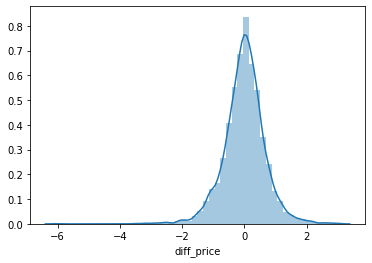

In [430]:
sns.distplot(df_fx["diff_price"])

In [431]:
df_fx.drop(["datetime", "time"], axis=1, inplace=True)
df_fx = df_fx[["date","diff_price","Open"]]
df_fx.head()

,date,diff_price,Open
613,20010103,-0.28,114.60
2006,20010104,2.08,114.32
3405,20010105,-0.09,116.40
4653,20010108,-0.50,116.31
6059,20010109,0.54,115.81


In [432]:
df_fx["date"] = pd.to_datetime(df_fx['date'].astype(str), format='%Y-%m-%d')
df_fx.head(1)

,date,diff_price,Open
613,2001-01-03,-0.28,114.6


In [433]:
print (end_date, start_date)
df_fx_selected = df_fx[(df_fx["date"]<=end_date) & (df_fx["date"]>=start_date)]
df_fx_selected.tail()

2017-12-31 2016-01-01


,date,diff_price,Open
5974958,2017-12-22,-0.09,113.36
5976272,2017-12-26,-0.10,113.27
5977650,2017-12-27,-0.41,113.17
5979090,2017-12-28,-0.18,112.76
5980530,2017-12-29,-0.21,112.58


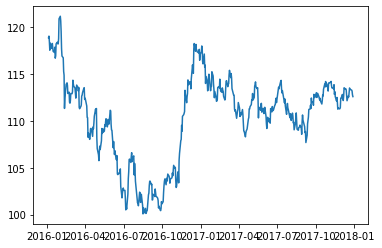

In [434]:
plt.plot(df_fx_selected["date"], df_fx_selected["Open"])

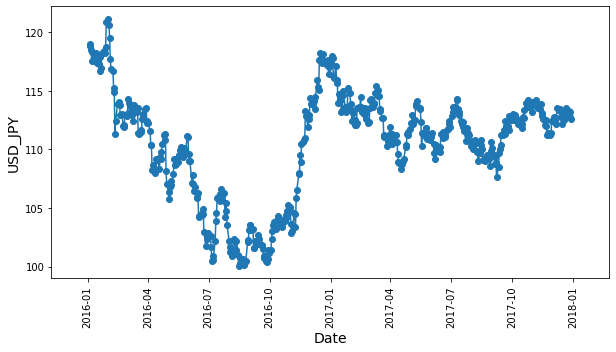

In [435]:
plt.figure(figsize=(10,5))
plt.scatter(df_fx_selected["date"],df_fx_selected["Open"])
plt.plot(df_fx_selected["date"],df_fx_selected["Open"])
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=14)
plt.ylabel('USD_JPY', fontsize=14)
plt.savefig('output/usdjpy_overall.png')

In [436]:
if surprise_level == 0:
    df_fx_selected["scaled_price"] = scale(df_fx_selected["diff_price"])
    df_fx_selected["sign"] = np.sign(df_fx_selected['diff_price'])
    print (df_fx_selected["sign"].unique())
    df_fx_selected["sign"] = np.where(df_fx_selected["sign"] == -1,2,df_fx_selected["sign"])
    print (df_fx_selected["sign"].unique())
elif surprise_level == 5:
    df_fx_selected["sign"] = 0
    df_fx_selected.loc[df_fx_selected['diff_price'] > 0.1, 'sign'] = 1
    df_fx_selected.loc[df_fx_selected['diff_price'] > 0.6, 'sign'] = 2
    df_fx_selected.loc[df_fx_selected['diff_price'] < -0.1, 'sign'] = -1 #3
    df_fx_selected.loc[df_fx_selected['diff_price'] < -0.6, 'sign'] = -2 #4
    print (df_fx_selected["sign"].unique())

[ 1. -1.  0.]
[1. 2. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



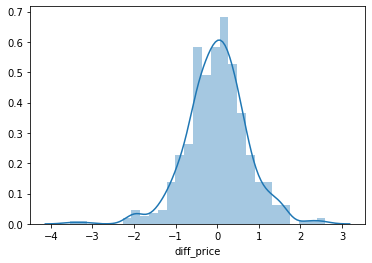

In [437]:
sns.distplot(df_fx_selected["diff_price"])

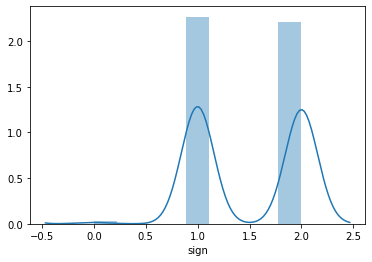

In [438]:
sns.distplot(df_fx_selected["sign"])

In [439]:
df_fx_selected.head(2)

,date,diff_price,Open,scaled_price,sign
5249548,2016-01-04,0.17,118.86,0.247883,1.0
5250988,2016-01-05,-0.58,119.03,-0.770654,2.0


# Combine FX and News data

In [440]:
df_fx_selected.dtypes

date            datetime64[ns]
diff_price      float64       
Open            float64       
scaled_price    float64       
sign            float64       
dtype: object

In [441]:
df_news.dtypes

date           datetime64[ns]
words          object        
category       object        
c2id           int64         
word_length    int64         
text           object        
dtype: object

In [442]:
df_news["c2id"].unique()

array([0, 1, 2])

In [443]:
df_merge = pd.merge(df_fx_selected, df_news, on="date")
df_merge.head(2)

,date,diff_price,Open,scaled_price,sign,words,category,c2id,word_length,text
0,2017-05-24,0.06,111.8,0.098498,1.0,"[18, 798, 5784, 1684, 454, 2394, 1034, 225, 5785, 10, 16, 5786, 1981, 163, 13]",BUSINESS,0,15,uber vows repay nyc drivers tens millions tax snafu company says miscalculated commission several years
1,2017-05-24,0.06,111.8,0.098498,1.0,"[27, 5787, 1768, 131, 1403, 5788, 2458, 1, 14, 5789, 2458]",CRIME,1,11,woman maced wendy employees serving stale fries police say beef fries


In [444]:
df_merge.tail(2)

,date,diff_price,Open,scaled_price,sign,words,category,c2id,word_length,text
552,2017-12-29,-0.21,112.58,-0.268176,2.0,"[1187, 314, 1186, 577, 14, 8, 1337, 27, 754, 12, 31, 67, 233, 754, 1942, 996, 353, 235, 166]",CRIME,1,19,nypd officers suspended witnesses say nt check woman later found dead victim daughter later discovered crying near mother body
553,2017-12-29,-0.21,112.58,-0.268176,2.0,"[579, 729, 1093, 382, 1978, 997, 53, 35, 150, 3516, 1979, 147]",IMPACT,2,12,big environmental stories watch lawsuits focused climate change another canadaus pipeline news


In [445]:
df_merge["category"].unique()

array(['BUSINESS', 'CRIME', 'IMPACT'], dtype=object)

In [446]:
pd.set_option('display.max_colwidth', -1)
df_merge[["date","sign","text"]].head(20)

,date,sign,text
0,2017-05-24,1.0,uber vows repay nyc drivers tens millions tax snafu company says miscalculated commission several years
1,2017-05-24,1.0,woman maced wendy employees serving stale fries police say beef fries
2,2017-05-24,1.0,food waste money drain benefits reducing food waste numerous
3,2017-05-24,1.0,expert conversation right luxury could constitute legitimate claim luxury exists human societies throughout world different forms gratisographypexels léa barreau
4,2017-05-24,1.0,behaviors highlight leadership ability based years experience new business advisor always find leadership important business success
5,2017-05-25,2.0,immigrant helped become better ceo america known land opportunity also center entrepreneurial innovation magnet talent
6,2017-05-25,2.0,pennsylvania drug counselors die opioid overdoses opioids monster slowly consuming population da says
7,2017-05-25,2.0,ways strategic influence different women miriam grobman almost four years thinking advancing women leadership talking hundreds individuals
8,2017-05-25,2.0,white house budget would increase hunger across america need find opportunities strengthen dismantle programs help lowincome families
9,2017-05-26,1.0,summer scams avoid weather gets warmer mosquitos ticks reenter lives along comes larger cousin scam


In [447]:
if calculation_mode == "surprise":
    # df_merge = df_merge[["date", "sign", "words","Open","bpe"]]
    df_merge = df_merge[["date", "sign", "words","Open","diff_price"]]
elif calculation_mode == "category":
    df_merge = df_merge[["date", "c2id", "words","bpe","text"]]
    df_merge["sign"] = df_merge["c2id"]
df_merge.head(1)

,date,sign,words,Open,diff_price
0,2017-05-24,1.0,"[18, 798, 5784, 1684, 454, 2394, 1034, 225, 5785, 10, 16, 5786, 1981, 163, 13]",111.8,0.06


In [448]:
df_merge.dtypes

date          datetime64[ns]
sign          float64       
words         object        
Open          float64       
diff_price    float64       
dtype: object

In [0]:
df_merge.to_csv("data/merge_data.csv")

In [0]:
# df_merge["c2id"].unique()

## split dataset

In [0]:
# split data 
if encoding_mode == "tokenize":
    # x_train, x_test, y_train, y_test = train_test_split(
    #     df_merge["words"].values, df_merge["sign"].values, test_size=0.33, random_state=42, shuffle=False)
    # x_train, x_test0, y_train, y_test0 = train_test_split(
    #     df_merge["words"].apply(eval).values, df_merge["sign"].values, test_size=0.30, random_state=42, shuffle=False)
    # x_validate, x_test, y_validate, y_test = train_test_split(
    #     x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
    x_train, x_test0, y_train, y_test0 = train_test_split(
        df_merge["words"].values, df_merge["sign"].values, test_size=0.30, random_state=42, shuffle=False)
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
elif encoding_mode == "bpe":
#     x_train, x_test, y_train, y_test = train_test_split(
#         df_merge["bpe"].values, df_merge["sign"].values, test_size=0.33, random_state=42, shuffle=False)    
    
    encode_data = df_merge["bpe"].values#apply(eval).values
    x_train, x_test0, y_train, y_test0 = train_test_split(
        encode_data, df_merge["sign"].values, test_size=0.33, random_state=42, shuffle=False)  
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)

In [0]:
# print (x_train)
# print (y_train)

In [455]:
print (type(x_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [456]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=pad_maxlen)
x_validate = sequence.pad_sequences(x_validate, maxlen=pad_maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=pad_maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
# print (x_train)
# print (y_train)

Pad sequences (samples x time)
x_train shape: (387, 50)
x_test shape: (84, 50)


In [457]:
from sklearn.preprocessing import LabelEncoder

# Encode text to labels
le = LabelEncoder()
le.fit(y_train)
train_labels_enc = le.transform(y_train)
validation_labels_enc = le.transform(y_validate)
test_labels_enc = le.transform(y_test)

print (y_train[0:4], train_labels_enc[0:4])
print (train_labels_enc.shape, test_labels_enc.shape)

[1. 1. 1. 1.] [0 0 0 0]
(387,) (84,)


In [458]:
from keras.utils import to_categorical
# Convert a vector label to matrix label
y_train_ohe = to_categorical(train_labels_enc)
y_validate_ohe = to_categorical(validation_labels_enc)
y_test_ohe = to_categorical(test_labels_enc)
print (y_train_ohe.shape,y_test_ohe.shape[0])

(387, 2) 84


## Run model

In [0]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

max_features = 20000
batch_size = 32

In [0]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y_train_ohe.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [0]:
print (x_train.shape, x_test.shape)
print (y_train_ohe.shape, y_test_ohe.shape)

In [0]:
print('Train...')
model_history = model.fit(x_train, y_train_ohe,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_validate, y_validate_ohe))
score, acc = model.evaluate(x_validate, y_validate_ohe,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

## plot accuracy

In [0]:
def plot_accuracy(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Transfer Learning Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_lenght = len(history.history['accuracy'])+1
    epoch_list = list(range(1,epoch_lenght))
    
    # Plot accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epoch_lenght, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    # Plot loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epoch_lenght, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
plot_accuracy(model_history)

In [0]:
test_model = model.predict_classes(x_train)
print (set(y_train), set(test_model))

In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def predict_model_confusion_matrix(x_train, y_train, model):
    predicted_labels = model.predict_classes(x_train)

    true_labels = y_train
    # get_metrics
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

    # confusion matrix
    labels = list(set(y_train))
    cm = confusion_matrix(y_train, predicted_labels, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm_labeled, annot=True, cmap='Greens', fmt='g')
    return
predict_model_confusion_matrix(x_train, np.argmax(y_train_ohe,1), model)

In [0]:
predict_model_confusion_matrix(x_validate, np.argmax(y_validate_ohe,1), model)

In [0]:
predict_model_confusion_matrix(x_test, np.argmax(y_test_ohe,1), model)

## visualise data using shap

In [0]:
# import shap

# # we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model, x_train[:100])

# # explain the first 10 predictions
# # explaining each prediction requires 2 * background dataset size runs
# shap_values = explainer.shap_values(x_test[:10])

# # init the JS visualization code
# shap.initjs()

# # transform the indexes to words
# words = word_index
# num2word = {}
# for w in words.keys():
#     num2word[words[w]] = w
# x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

# # plot the explanation of the first prediction
# # Note the model is "multi-output" because it is rank-2 but only has one column
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0])